In [1]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

import pandas as pd
import re
import warnings; warnings.simplefilter('ignore')
import numpy as np
import warnings
import os
import sys
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from src.models.lda_feature_builder import addLDA    
from src.data.read_parallel import read_parallel_local
from src.models.data_loader import createDeepLegisDataFrame
from src.models.configurationClasses import deepLegisConfig

config = deepLegisConfig('bert_128.json', project_root="../")

In [2]:
df, encoder = createDeepLegisDataFrame(config)

Original number of examples: 199646
Loading 199646 text files
Took 12.328851099809011 min to open 199646 files with 20 processes.


In [3]:
sc_id_counts = df[['sc_id', 'id']].groupby('sc_id').count().sort_values('id').reset_index()
sc_id_counts = sc_id_counts[sc_id_counts.id >=20]
sc_id_counts.shape
df = df.merge(sc_id_counts[['sc_id']], on='sc_id')

In [4]:
df.head()

,id,version_number,bill_id,signed,passed,partisan_lean,sc_id,sc_id_cat,text
0,2708956,10,1092981,0,0,0.236118,562-1,6,amendment no. to hb0001 miller signature of s...
1,2127866,1,1098149,1,1,0.236118,562-1,6,<billno> <sponsor> senate joint resolution by...
2,2127963,1,1098199,0,0,0.236118,562-1,6,<billno> <sponsor> senate bill by massey an a...
3,2128334,1,1098465,0,0,0.236118,562-1,6,<billno> <sponsor> senate bill by gresham an ...
4,2128986,1,1098872,1,1,0.236118,562-1,6,<billno> <sponsor> senate joint resolution by...


In [5]:
import gensim
from gensim.utils import simple_preprocess
import pickle

def dense_vector(ldav, n):
    v = [0]*n
    for (i, p) in ldav:
        v[i] = p
    return tuple(v)

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [6]:
def print_performance_metrics(truth, pred, alg_text = ""):
    
    cr = classification_report(truth, pred > 0.5)
    print(cr)
    
    print(confusion_matrix(truth, pred>0.5))
    
    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(truth, pred, pos_label=1)
    print(f"N thresholds: {len(thresholds)}")
        
    roc_auc = roc_auc_score(Y_test, pred)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(alg_text + ' ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


In [7]:
# test-train split used throughout.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

X = df[['partisan_lean', 'version_number', 'sc_id', 'text']]
Y = df[['passed']]

(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.08, random_state=0)

print(f"X_train shape:{X_train.shape}")
print(f"X_test shape:{X_test.shape}")

X_train shape:(183641, 4)
X_test shape:(15969, 4)


In [8]:
n_topics = 40
with open('bow_models/lda_40_10.dat', "rb") as f:
    [lda_model, id2word] = pickle.load(f)
    
categorical_features = ['sc_id']
categorical_transformer = OneHotEncoder(sparse=False)

numeric_features = ['version_number', 'partisan_lean']
numeric_transformer = Pipeline(steps=[ ('scaler', StandardScaler()) ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
        ('text', addLDA(lda_model, id2word, n_topics), ['text'])
        
])
lr_model = LogisticRegression(penalty='l1', solver='liblinear')
lr = Pipeline(steps = [ ('prep', preprocessor),
                        ('Logistic Regression', lr_model) ])
lr.fit(X_train, Y_train);

              precision    recall  f1-score   support

           0       0.90      0.97      0.93     13385
           1       0.73      0.42      0.54      2584

    accuracy                           0.88     15969
   macro avg       0.82      0.70      0.74     15969
weighted avg       0.87      0.88      0.87     15969

[[12987   398]
 [ 1486  1098]]
N thresholds: 2745


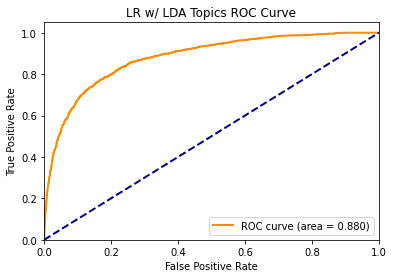

In [9]:
preds = lr.predict_proba(X_test)
print_performance_metrics(Y_test.passed, preds[:,1] , "LR w/ LDA Topics")

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     13385
           1       0.77      0.56      0.65      2584

    accuracy                           0.90     15969
   macro avg       0.84      0.77      0.80     15969
weighted avg       0.90      0.90      0.90     15969

[[12947   438]
 [ 1129  1455]]
N thresholds: 2528


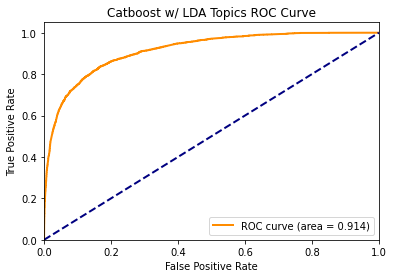

In [10]:
from catboost import CatBoostClassifier, Pool, cv

categorical_features_indices = [2]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('sc_id', 'passthrough', [2]),
        ('text', addLDA(lda_model, id2word, n_topics), ['text'])
        
])
cat_model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    cat_features = [2]
)
cat = Pipeline(steps = [ ('prep', preprocessor),
                         ('Catboost', cat_model) ])
cat.fit(X_train, Y_train)
preds = cat.predict_proba(X_test)
print_performance_metrics(Y_test.passed, preds[:,1] , "Catboost w/ LDA Topics")

In [11]:
import joblib
#joblib.dump(cat, 'prod_model.joblib')

In [ ]:
from catboost import CatBoost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


pl = Pipeline(steps = [ ('prep', preprocessor)])
X_ready = pl.transform(X)
print(X_ready.shape)


In [ ]:
cat_model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    cat_features = [2]
)
results = cat_model.grid_search({'depth':[3,5,8], 'learning_rate':[0.03, 0.1, 0.3]}, 
                                X_ready, y=Y, cv=3, plot=True)

In [ ]:
print(df_ml_x.shape)
df_ml_y = df[['passed']].values
(X_train, X_test, Y_train, Y_test) = train_test_split(df_ml_x, df_ml_y, test_size=0.08, random_state=0)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train, Y_train.ravel())
pred = clf.predict_proba(X_test)[:,1]
print_performance_metrics(Y_test, pred, alg_text = "Logistic Regression w/ Topic Vectors")

In [ ]:
df_ml_x = np.concatenate((df[['partisan_lean', 'version_number']].values, sparse_one_hot.toarray()), axis=1)
df_ml_y = df[['passed']].values
(X_train, X_test, Y_train, Y_test) = train_test_split(df_ml_x, df_ml_y, test_size=0.08, random_state=0)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train, Y_train.ravel())
pred = clf.predict_proba(X_test)[:,1]
print_performance_metrics(Y_test, pred, alg_text = "Logistic Regression w/o Topic Vectors")

In [ ]:
from catboost import CatBoostClassifier, Pool, cv
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
df_cat_x = np.concatenate((df[['partisan_lean', 'version_number', 'sc_id']].values, features), axis=1)
categorical_features_indices = [2]
df_cat_y = df[['passed']]

# redo the test_train split as we don't have sc_id oneHotEncoded
(X_train, X_test, Y_train, Y_test) = train_test_split(df_cat_x, df_cat_y, test_size=0.2, random_state=0)
model.fit(
    X_train, Y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, Y_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);
preds_cat = model.predict_proba(X_test)[:,1]
print_performance_metrics(Y_test.values, preds_cat, alg_text = "Categorical gradient boost w/ Topic Vectors")

In [ ]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
df_cat_x =  df[['partisan_lean', 'version_number', 'sc_id']].values
categorical_features_indices = [2]
df_cat_y = df[['passed']]

# redo the test_train split as we don't have sc_id oneHotEncoded
(X_train, X_test, Y_train, Y_test) = train_test_split(df_cat_x, df_cat_y, test_size=0.2, random_state=0)
model.fit(
    X_train, Y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, Y_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);
preds_cat = model.predict_proba(X_test)[:,1]
print_performance_metrics(Y_test.values, preds_cat, alg_text = "Categorical gradient boost w/o Topic Vectors")

In [ ]:
from gensim.models import LsiModel
n_lsi_topics = 50
lsi_model = LsiModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=n_lsi_topics)
doc_topics_lsi = [dense_vector(lsi_model[x], n_lsi_topics) for x in corpus]
features_lsi = np.asarray(doc_topics_lsi)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix
#Creat target and features:
enc = OneHotEncoder(drop='first')
enc.fit(df.sc_id.values.reshape(-1,1))
sparse_one_hot = enc.transform(df.sc_id.values.reshape(-1,1))
df_ml_x = np.concatenate((df[['partisan_lean', 'version_number']].values, sparse_one_hot.toarray(), features_lsi), axis=1)
df_ml_y = df[['passed']].values
(X_train, X_test, Y_train, Y_test) = train_test_split(df_ml_x, df_ml_y, test_size=0.08, random_state=0)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train, Y_train.ravel())
pred = clf.predict_proba(X_test)[:,1]
print_performance_metrics(Y_test, pred, alg_text = "Logistic Regression w/ LSI")

In [ ]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
df_cat_x = np.concatenate((df[['partisan_lean', 'version_number', 'sc_id']].values, features_lsi), axis=1)
categorical_features_indices = [2]
df_cat_y = df[['passed']]

# redo the test_train split as we don't have sc_id oneHotEncoded
(X_train, X_test, Y_train, Y_test) = train_test_split(df_cat_x, df_cat_y, test_size=0.2, random_state=0)
model.fit(
    X_train, Y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, Y_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);
preds_cat = model.predict_proba(X_test)[:,1]
print_performance_metrics(Y_test.values, preds_cat, alg_text = "Categorical gradient boost w/ LSI")